In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
df_3er_and_4er_forum_posts_extended = pd.read_pickle("data/3er_and_4er_forum_posts_extended.pkl")
df_3er_and_4er_forum_threads = pd.read_pickle("data/3er_and_4er_forum_threads.pkl")

In [3]:
def attribute_description(data):
    longestColumnName = len(max(np.array(data.columns), key=len))
    length_first_col = longestColumnName + 1
    print("| " + "Feature".ljust(length_first_col) + "| Data Type |")
    print("|" + "-" * (length_first_col + 1) + "|-----------|")
    for col in data.columns:
        description = ""
        col_dropna = data[col].dropna()
        if col_dropna.empty:
            description += " -- col is empty --"
        else:
            example = col_dropna.sample(1).values[0]
            # if it is a string
            if type(example) == str:
                description = "str "
                if len(col_dropna.unique()) < 10:
                    description += "{"
                    description += "; ".join([f'"{name}"' for name in col_dropna.unique()])
                    description += "}"
                else:
                    description += '[ example: "' + example + '" ]'
            # if it is a typical dummy variable int32 with less then 10 entries
            elif (type(example) == np.int32) and (len(col_dropna.unique()) < 10):
                description += "dummy int32 {"
                description += "; ".join([f"{name}" for name in sorted(col_dropna.unique())])
                description += "}"
            # if it is a numpy type
            elif "numpy" in str(type(example)):
                kind = example.dtype.kind
                if kind == "i" or kind == "u" or kind == "f" or kind == "c":  # if it is a number
                    description = f"{('numpy.'+str(example.dtype)).ljust(10)} [ {col_dropna.min()}; {col_dropna.max()} ]"
                else:
                    description = type(example)
            else:
                description = type(example)
        print("| " + col.ljust(length_first_col) + f"| {description} |")


attribute_description(df_3er_and_4er_forum_posts_extended)

| Feature        | Data Type |
|----------------|-----------|
| Post_ID        | str [ example: "20944062" ] |
| Username       | str [ example: "adamnur" ] |
| Posted_on_Date | <class 'numpy.datetime64'> |
| content        | str [ example: "Replaced my 15 yr old worn out and faded BMW roundels from the hood and trunk
with black and white ones.

" ] |
| Thread_ID      | str [ example: "1471423" ] |
| Subsubforum    | str {"143-1975-1983-(E21)"; "20-1983-1991-(E30)"; "14-1991-1999-(E36)"; "15-1999-2006-(E46)"; "189-2006-2012-(E90-E91-E92-E93)"; "333-2012-2019-(F30-F32-F33-F34-F36)"; "376-2018-(3-Series-sub-(G20-G22-G23-G24)"} |


<Axes: xlabel='Subsubforum'>

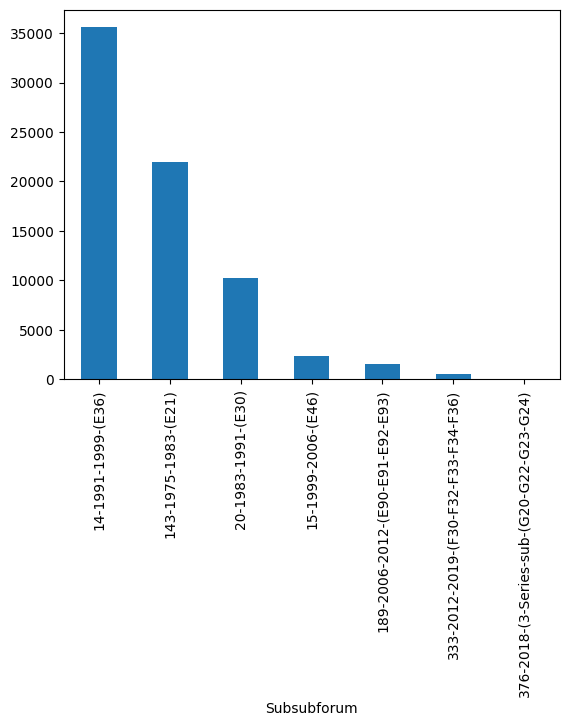

In [4]:
# I want to check how many posts there are for each subsubforum
df_3er_and_4er_forum_posts_extended["Subsubforum"].value_counts().plot(kind="bar")

In [5]:
df_3er_and_4er_forum_posts_extended["Thread_ID"].value_counts()

Thread_ID
1241671    17654
142866      6785
1043073     5914
1471423     5145
1899597     3416
           ...  
2479631        1
2479698        1
2479725        1
2479870        1
2478506        1
Name: count, Length: 2291, dtype: int64

<Axes: xlabel='number of posts in thread', ylabel='number of threads'>

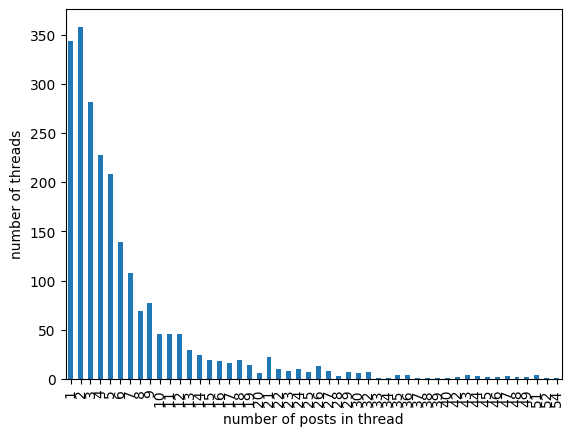

In [6]:
# count the amounts of threads with only one post (questions without answers)
df_3er_and_4er_forum_posts_extended["Thread_ID"].value_counts().value_counts().sort_index()[:50].plot(kind="bar", xlabel="number of posts in thread", ylabel="number of threads")

In [14]:
# count the number of words in all the posts:
wordcount = df_3er_and_4er_forum_posts_extended["content"].str.split().apply(len)
wordcount.sort_values()

39808        0
43237        0
15081        0
8041         0
57417        0
         ...  
70368     8866
70367     8870
68186    10220
67198    14165
69385    15705
Name: content, Length: 72376, dtype: int64

<Axes: ylabel='Frequency'>

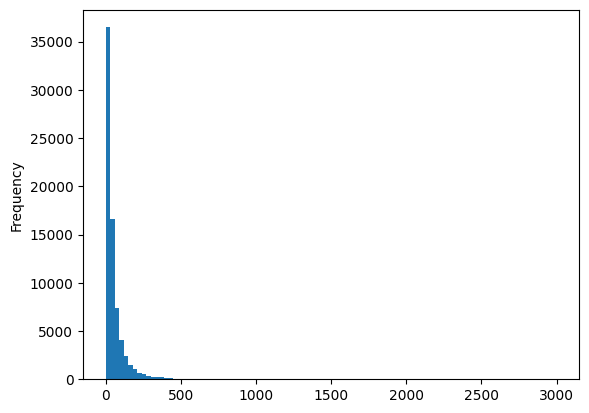

In [15]:
wordcount.sort_values().plot(kind="hist", bins=100, range=(0, 3000))

In [16]:
wordcount.sum()

4078144

In [24]:
# calculate how much it costs to refactor the content with mistral-medium
# pipe all threads through mistral-medium, and give it a system prompt to clean up the thread.
# remove useless content, improve content etc.
# The input would be the number of words * 1.3 + number of threads * 200 * 1.3
# the output would be the number of words * 0.6 * 1.3
# 1.3 is the average number of tokens per word
# 200 is the length of the system prompt
# 0.6 is the percentage of content left after cleaning up

input_words = wordcount.sum()
number_of_threads = df_3er_and_4er_forum_posts_extended["Thread_ID"].nunique()
num_input_tokens = input_words * 1.3 + 200 * number_of_threads * 1.3
num_output_tokens = input_words * 0.6 * 1.3
cost_in_dollars = num_input_tokens *0.65 / 1e6 + num_output_tokens * 0.65 / 1e6
print(f"{cost_in_dollars:.2f} €")

5.90 €


| Model	| Endpoint| 	Input (USD) | 	Output (USD)	 | Input (EUR)	|  Output (EUR)
|-|-|-|-|-|-| 
|Mistral 7B |	open-mistral-7b	  |0.25$ / 1M tokens	| 0.25$ / 1M tokens	| 0.2€ / 1M tokens	| 0.2€ / 1M tokens |
|Mixtral 8x7B|	open-mixtral-8x7b	|0.7$ / 1M tokens	| 0.7$ / 1M tokens	| 0.65€ / 1M tokens	| 0.65€ / 1M tokens |

Cohere Embedding Cost = 0.1 $ / M Tokens

In [27]:
# Cost for embedding all the content for The RAG System:
# Cohere Embedding Cost = 0.1 $ / M Tokens
cost_for_embedding = input_words *0.6 * 0.1 / 1e6
print(f"{cost_for_embedding:.2f} $")

0.24 €
